In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from einops import rearrange

In [2]:
def compute_mhsa(q, k, v, scale_factor=1, mask=None):
    # resulted shape will be: [batch, heads, tokens, tokens]
    scaled_dot_prod = torch.einsum('... i d , ... j d -> ... i j', q, k) * scale_factor

    if mask is not None:
        assert mask.shape == scaled_dot_prod.shape[2:]
        scaled_dot_prod = scaled_dot_prod.masked_fill(mask, -np.inf)

    attention = torch.softmax(scaled_dot_prod, dim=-1)
    # calc result per head
    return torch.einsum('... i j , ... j d -> ... i d', attention, v)

def project_vk_linformer(v, k, E):
    # project k,v
    v = torch.einsum('b h j d , j k -> b h k d', v, E)
    k = torch.einsum('b h j d , j k -> b h k d', k, E)
    return v, k

In [3]:
class LinformerAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=None, shared_projection=False, proj_shape=(20,22), trainable_proj=True):
        """
        Based on the Linformer paper
        Link: https://arxiv.org/pdf/2006.04768.pdf
        Args:
            dim: token's dimension, i.e. word embedding vector size
            heads: the number of distinct representations to learn
            dim_head: the dim of the head.
            shared_projection: if the projection matrix will be shared among layers
            (it will have to be passed in the forward that way)
            trainable_proj: if the projection matrix E matrix is not shared,
            you can enable this option to make it trainable (non trainable in the paper)
            proj_shape: 2-tuple (tokens,k), where k is the projection dimension of the linformer
            """
        super().__init__()
        self.dim_head = (int(dim / heads)) if dim_head is None else dim_head
        _dim = self.dim_head * heads
        self.heads = heads
        self.to_qvk = nn.Linear(dim, _dim * 3, bias=False)
        self.W_0 = nn.Linear(_dim, dim, bias=False)
        self.scale_factor = self.dim_head ** -0.5
        self.shared_projection = shared_projection

        if not shared_projection:
            self.E = torch.nn.Parameter(torch.randn(proj_shape), requires_grad=trainable_proj)
            self.k = proj_shape[1]

    def forward(self, x, proj_mat=None):
        assert x.dim() == 3
        E = proj_mat if (self.shared_projection and proj_mat is not None) else self.E
        assert x.shape[1] == E.shape[0], f'{x.shape[1]} Token in the input sequence while' \
                                         f' {E.shape[0]} were provided in the E proj matrix'

        qkv = self.to_qvk(x)  # [batch, tokens, dim*3*heads ]
        q, k, v = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.heads))

        v, k = project_vk_linformer(v, k, E)

        out = compute_mhsa(q, k, v, scale_factor=self.scale_factor)
        # re-compose: merge heads with dim_head

        out = rearrange(out, "b h i d -> b i (h d)")
        # Apply final linear transformation layer
        return self.W_0(out)

In [4]:
class EncoderLayer(nn.Module):
    def __init__(self, num_heads, d_model, d_ff, dropout):
        super().__init__()

        self.dec_attn = LinformerAttention(dim=d_model, heads=num_heads)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.positionwise_feedforward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x, dec_attn_mask=None, mems=None):
               
        attention_output = self.dec_attn(x)
        x = self.layer_norm1(x + self.dropout(attention_output))
        feedforward_output = self.positionwise_feedforward(x)
        x = self.layer_norm2(x + self.dropout(feedforward_output))
        return x

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=20):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) #.transpose(0, 1)
        self.register_buffer('pe', pe)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x + self.pe.repeat(x.size(0),1,1)
        x = self.dropout(x)
        return x

In [6]:
class Linformer(nn.Module):
    def __init__(self, num_layers, num_heads, d_model, d_ff, dropout):
        super().__init__()

        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.encoder_layers = nn.ModuleList([EncoderLayer(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout) for _ in range(num_layers)])
#        self.decoder_layers = nn.ModuleList([DecoderLayer(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout) for _ in range(num_layers)])

        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(d_model, 1)
        
    def forward(self, input_ids):

        input_embeddings = input_ids

        # Apply positional encoding
        input_embeddings = self.positional_encoding(input_embeddings)

        # Encode inputs
        for layer in self.encoder_layers:
            input_embeddings = layer(input_embeddings)


        output=torch.mean(input_embeddings,dim=1,keepdim=False)
        output = F.relu(self.flatten(output))
        output = self.final_layer(output)
        
        return output

In [7]:
num_layers = 2
num_heads = 2
d_model = 22
d_ff = 64
dropout = 0
model = Linformer(num_layers=num_layers, num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout)

input_ids = torch.rand(10,20,22)
output = model(input_ids)
print(output.shape)
print(output)

torch.Size([10, 1])
tensor([[0.1944],
        [0.2482],
        [0.2011],
        [0.2859],
        [0.2785],
        [0.2490],
        [0.2290],
        [0.3293],
        [0.2723],
        [0.2454]], grad_fn=<AddmmBackward0>)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [10]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [11]:
df_for_training=df[feature_names].astype(float)

In [12]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [13]:
trainX=[]
trainY=[]

In [14]:
n_future=1
n_past=20

In [15]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [16]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [17]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [18]:
data,label=trainX,trainY

In [19]:
def standardization(data):
    mu = np.min(data)
    sigma = np.max(data)-np.min(data)
    return (data - mu) / sigma

In [20]:
for j in range(0,data.shape[2]):
    data[:,:,j]=standardization(data[:,:,j])

In [21]:
label=standardization(label)

In [22]:
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data,  label)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [24]:
for epoch in range(1000):
    
    losses = []
    for batch_idx, (data1, targets) in enumerate(train_loader):
        #import pdb;pdb.set_trace()
        output = model(data1)
       
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())

    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.8832335472106934
Epoch: 1 Loss: 1.0224941968917847
Epoch: 2 Loss: 0.87578946352005
Epoch: 3 Loss: 0.8956635594367981
Epoch: 4 Loss: 0.7168377041816711
Epoch: 5 Loss: 0.7013762593269348
Epoch: 6 Loss: 0.6597545742988586
Epoch: 7 Loss: 0.6841627359390259
Epoch: 8 Loss: 0.6250841021537781
Epoch: 9 Loss: 1.0238502025604248
Epoch: 10 Loss: 0.8046107292175293
Epoch: 11 Loss: 0.648301362991333
Epoch: 12 Loss: 0.9721665382385254
Epoch: 13 Loss: 0.8583105802536011
Epoch: 14 Loss: 0.7222051620483398
Epoch: 15 Loss: 0.6308987736701965
Epoch: 16 Loss: 0.6546224355697632
Epoch: 17 Loss: 0.8265732526779175
Epoch: 18 Loss: 0.7661745548248291
Epoch: 19 Loss: 0.6258037090301514
Epoch: 20 Loss: 0.8256428241729736
Epoch: 21 Loss: 0.606170117855072
Epoch: 22 Loss: 1.007176399230957
Epoch: 23 Loss: 0.6469210386276245
Epoch: 24 Loss: 0.6039333939552307
Epoch: 25 Loss: 0.8721632361412048
Epoch: 26 Loss: 0.5880348682403564
Epoch: 27 Loss: 0.8923101425170898
Epoch: 28 Loss: 0.5819346904754639


Epoch: 231 Loss: 0.4422341585159302
Epoch: 232 Loss: 0.4646887183189392
Epoch: 233 Loss: 0.4544241726398468
Epoch: 234 Loss: 0.43876633048057556
Epoch: 235 Loss: 0.46152031421661377
Epoch: 236 Loss: 0.45765921473503113
Epoch: 237 Loss: 0.4310723543167114
Epoch: 238 Loss: 0.5207546353340149
Epoch: 239 Loss: 0.47319355607032776
Epoch: 240 Loss: 0.40001896023750305
Epoch: 241 Loss: 0.5234623551368713
Epoch: 242 Loss: 0.4088395833969116
Epoch: 243 Loss: 0.4296388030052185
Epoch: 244 Loss: 0.4253309965133667
Epoch: 245 Loss: 0.39215102791786194
Epoch: 246 Loss: 0.44241660833358765
Epoch: 247 Loss: 0.4402564764022827
Epoch: 248 Loss: 0.45587414503097534
Epoch: 249 Loss: 0.43012407422065735
Epoch: 250 Loss: 0.4466104507446289
Epoch: 251 Loss: 0.4672207832336426
Epoch: 252 Loss: 0.4800482392311096
Epoch: 253 Loss: 0.3947237730026245
Epoch: 254 Loss: 0.4321098327636719
Epoch: 255 Loss: 0.3733861446380615
Epoch: 256 Loss: 0.6760578155517578
Epoch: 257 Loss: 0.45850905776023865
Epoch: 258 Loss: 0

Epoch: 457 Loss: 0.3743530511856079
Epoch: 458 Loss: 0.39183691143989563
Epoch: 459 Loss: 0.3564791679382324
Epoch: 460 Loss: 0.3664165735244751
Epoch: 461 Loss: 0.33211249113082886
Epoch: 462 Loss: 0.31813371181488037
Epoch: 463 Loss: 0.5296789407730103
Epoch: 464 Loss: 0.41658473014831543
Epoch: 465 Loss: 0.32912927865982056
Epoch: 466 Loss: 0.3707796633243561
Epoch: 467 Loss: 0.5041886568069458
Epoch: 468 Loss: 0.32913240790367126
Epoch: 469 Loss: 0.3649832010269165
Epoch: 470 Loss: 0.349691778421402
Epoch: 471 Loss: 0.3243095278739929
Epoch: 472 Loss: 0.3197808861732483
Epoch: 473 Loss: 0.37161338329315186
Epoch: 474 Loss: 0.33212924003601074
Epoch: 475 Loss: 0.29099294543266296
Epoch: 476 Loss: 0.3614003658294678
Epoch: 477 Loss: 0.32931283116340637
Epoch: 478 Loss: 0.3409106135368347
Epoch: 479 Loss: 0.3187922239303589
Epoch: 480 Loss: 0.2851758599281311
Epoch: 481 Loss: 0.6238234639167786
Epoch: 482 Loss: 0.3582306504249573
Epoch: 483 Loss: 0.3938906192779541
Epoch: 484 Loss: 0.

Epoch: 682 Loss: 0.31864288449287415
Epoch: 683 Loss: 0.2452581226825714
Epoch: 684 Loss: 0.27007371187210083
Epoch: 685 Loss: 0.24892659485340118
Epoch: 686 Loss: 0.23874767124652863
Epoch: 687 Loss: 0.23409605026245117
Epoch: 688 Loss: 0.2377415895462036
Epoch: 689 Loss: 0.23520870506763458
Epoch: 690 Loss: 0.23935577273368835
Epoch: 691 Loss: 0.2937221825122833
Epoch: 692 Loss: 0.2836829125881195
Epoch: 693 Loss: 0.2336643487215042
Epoch: 694 Loss: 0.236470028758049
Epoch: 695 Loss: 0.224686861038208
Epoch: 696 Loss: 0.4027876853942871
Epoch: 697 Loss: 0.2671060264110565
Epoch: 698 Loss: 0.2559160888195038
Epoch: 699 Loss: 0.22485487163066864
Epoch: 700 Loss: 0.278877854347229
Epoch: 701 Loss: 0.2301344871520996
Epoch: 702 Loss: 0.2615048885345459
Epoch: 703 Loss: 0.2295733243227005
Epoch: 704 Loss: 0.2549609839916229
Epoch: 705 Loss: 0.20621128380298615
Epoch: 706 Loss: 0.3298601806163788
Epoch: 707 Loss: 0.23295475542545319
Epoch: 708 Loss: 0.33435580134391785
Epoch: 709 Loss: 0.2

Epoch: 907 Loss: 0.24655325710773468
Epoch: 908 Loss: 0.2615714371204376
Epoch: 909 Loss: 0.28790587186813354
Epoch: 910 Loss: 0.24134206771850586
Epoch: 911 Loss: 0.35883229970932007
Epoch: 912 Loss: 0.31598135828971863
Epoch: 913 Loss: 0.22811093926429749
Epoch: 914 Loss: 0.2098507583141327
Epoch: 915 Loss: 0.2561107277870178
Epoch: 916 Loss: 0.2633955478668213
Epoch: 917 Loss: 0.2179681658744812
Epoch: 918 Loss: 0.25959891080856323
Epoch: 919 Loss: 0.30671846866607666
Epoch: 920 Loss: 0.23489096760749817
Epoch: 921 Loss: 0.21400952339172363
Epoch: 922 Loss: 0.3424181342124939
Epoch: 923 Loss: 0.2399897575378418
Epoch: 924 Loss: 0.25636279582977295
Epoch: 925 Loss: 0.23869766294956207
Epoch: 926 Loss: 0.275621235370636
Epoch: 927 Loss: 0.21800382435321808
Epoch: 928 Loss: 0.2560383081436157
Epoch: 929 Loss: 0.27768662571907043
Epoch: 930 Loss: 0.2674132287502289
Epoch: 931 Loss: 0.20438776910305023
Epoch: 932 Loss: 0.24009168148040771
Epoch: 933 Loss: 0.1940675973892212
Epoch: 934 Lo

In [25]:
trainX_copy_=trainX_copy
trainY_copy_=trainY_copy

In [26]:
for j in range(0,trainX_copy_.shape[2]):
    trainX_copy_[:,:,j]=standardization(trainX_copy_[:,:,j])

In [27]:
trainY_copy_=standardization(trainY_copy_)

In [28]:
test_data = torch.from_numpy(trainX_copy_).float()
test_label = torch.from_numpy(trainY_copy_).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [29]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    output=model(data)
    predictions+=output.tolist()

In [30]:
predictions = np.array(predictions)

In [31]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

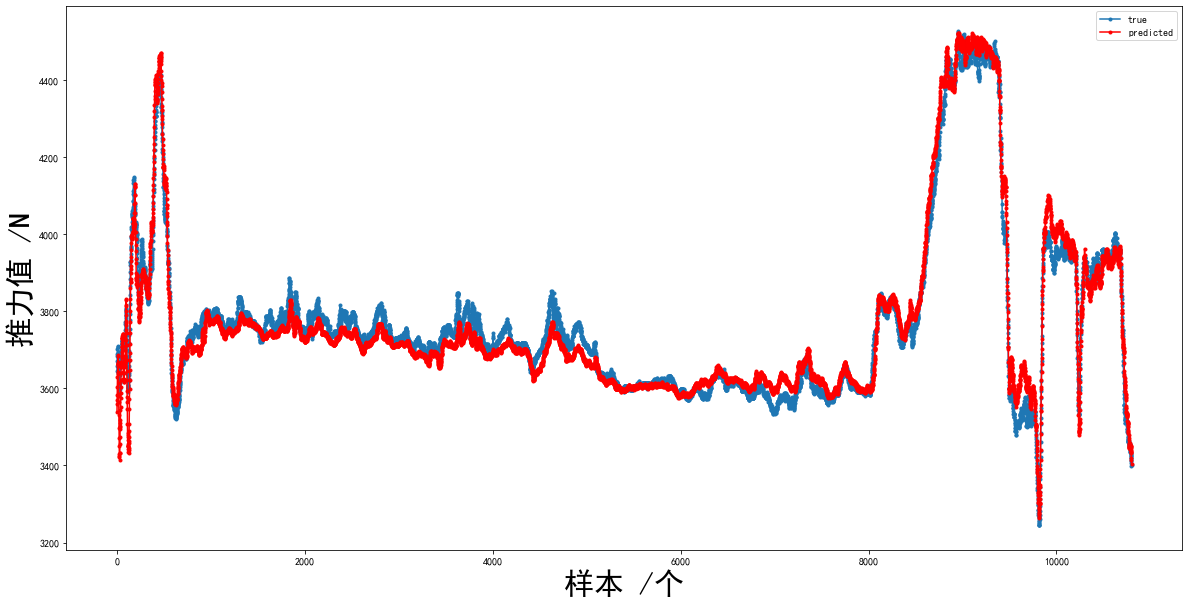

In [32]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot((predictions*19043.454262518393+23.9856747376088)[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend(); 